##  Double descent in two layer neural network
This notebook contains the relevant code for the following figures in the paper "*Early stopping in deep networks: Double descent and how to eliminate it*":

- Figure 4

In [2]:
#!/usr/bin/env python
# coding: utf-8

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import argparse
import os
import datetime
import pathlib
import random
import json
import numpy as np
import math

import torch

import sys
sys.path.append('../code/')
from linear_utils import linear_model
from train_utils import save_config

In [3]:
# argument written in command line format
cli_args = '--seed 12 --risk-loss L1 -t 50000 -w 1 0.01 --lr 0.000001 0.00008 -d 50 -n 100 --hidden 250 --sigmas geo --s-range 1 4'

In [4]:
"""
A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing the MSE loss.
"""

# get CLI parameters
parser = argparse.ArgumentParser(description='CLI parameters for training')
parser.add_argument('--root', type=str, default='', metavar='DIR',
                    help='Root directory')
parser.add_argument('-t', '--iterations', type=int, default=1e4, metavar='ITERATIONS',
                    help='Iterations (default: 1e4)')
parser.add_argument('-n', '--samples', type=int, default=100, metavar='N',
                    help='Number of samples (default: 100)')
parser.add_argument('--print-freq', type=int, default=100,
                    help='CLI output printing frequency (default: 1000)')
parser.add_argument('--gpu', type=int, default=None,
                    help='Number of GPUS to use')
parser.add_argument('--seed', type=int, default=None,
                    help='Random seed')                        
parser.add_argument('-d', '--dim', type=int, default=50, metavar='DIMENSION',
                    help='Feature dimension (default: 50)')
parser.add_argument('--hidden', type=int, default=200, metavar='DIMENSION',
                    help='Hidden layer dimension (default: 200)')
parser.add_argument('--sigmas', type=str, default=None,
                    help='Sigmas')     
parser.add_argument('-r','--s-range', nargs='*', type=float,
                    help='Range for sigmas')
parser.add_argument('-w','--scales', nargs='*', type=float,
                    help='scale of the weights')
parser.add_argument('--lr', type=float, default=1e-4, nargs='*', metavar='LR',
                    help='learning rate (default: 1e-4)')              
parser.add_argument('--normalized', action='store_true', default=False,
                    help='normalize sample norm across features')
parser.add_argument('--risk-loss', type=str, default='MSE', metavar='LOSS',
                    help='Loss for validation')
parser.add_argument('--save-results', action='store_true', default=False,
                    help='Save the results for plots')
parser.add_argument('--details', type=str, metavar='N',
                    default='no_detail_given',
                    help='details about the experimental setup')


args = parser.parse_args(cli_args.split())

# directories
root = pathlib.Path(args.root) if args.root else pathlib.Path.cwd().parent

current_date = str(datetime.datetime.today().strftime('%Y-%m-%d-%H-%M-%S'))
args.outpath = (pathlib.Path.cwd().parent / 'results' / 'two_layer_nn' /  current_date)

if args.save_results:
    args.outpath.mkdir(exist_ok=True, parents=True)

if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [5]:
d_out = 1      # dimension of y

# sample training set from the linear model
lin_model = linear_model(args.dim, sigma_noise=0.0, normalized=False, sigmas=args.sigmas, s_range=args.s_range)
Xs, ys = lin_model.sample(args.samples)
Xs = torch.Tensor(Xs).to(device)
ys = torch.Tensor(ys.reshape((-1,1))).to(device)

# sample the set for empirical risk calculation
Xt, yt = lin_model.sample(args.samples)
Xt = torch.Tensor(Xt).to(device)
yt = torch.Tensor(yt.reshape((-1,1))).to(device)

### Scaled stepsize

In [ ]:
# Two layer neural network in pytorch
model = torch.nn.Sequential(
          torch.nn.Linear(args.dim, args.hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(args.hidden, d_out),
        ).to(device)


#### re-initialize the weights (regular initialization is too unstable)
# if args.scales:
#     i = 0
#     with torch.no_grad():
#         for m in model:
#             if type(m) == torch.nn.Linear:
#                 if i == 0:
#                     m.weight.data.normal_(0, args.scales[0])
#                 if i == 1:
#                     m.weight.data.uniform_(-args.scales[1], args.scales[1])
#                 i += 1
                
                
# use kaiming initialization instead                
if args.scales:
    i = 0
    with torch.no_grad():
        for m in model:
            if type(m) == torch.nn.Linear:
                if i == 0:
                    torch.nn.init.kaiming_normal_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[0])
                if i == 1:
                    torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[1])
                i += 1
                

# use same learning rate for the two layers in case of a single learning rate or none.
if isinstance(args.lr, float):
    args.lr = [args.lr] * 2

In [ ]:
# define loss functions
loss_fn = torch.nn.MSELoss(reduction='sum')
risk_fn = torch.nn.L1Loss(reduction='mean') if args.risk_loss == 'L1' else loss_fn

# train the network
losses = []
risks = []
for t in range(int(args.iterations)):
    y_pred = model(Xs)

    loss = loss_fn(y_pred, ys)
    losses.append(loss.item())

    if not t % args.print_freq:
        print(t, loss.item())
        
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        for param in model.parameters():
            param.data -= args.lr[i] * param.grad
            if not len(param.shape) > 1:
                i += 1
            
    with torch.no_grad():
        yt_pred = model(Xt)
        
        risk = risk_fn(yt_pred, yt)
        risks.append(risk.item())

        if not t % args.print_freq:
            print(t, risk.item())

### Same stepsize

Train the network with the same stepsizes for both layers

In [ ]:
model2 = torch.nn.Sequential(
           torch.nn.Linear(args.dim, args.hidden),
           torch.nn.ReLU(),
           torch.nn.Linear(args.hidden, d_out),
         ).to(device)      
                
# use kaiming initialization                
if args.scales:
    i = 0
    with torch.no_grad():
        for m in model2:
            if type(m) == torch.nn.Linear:
                if i == 0:
                    torch.nn.init.kaiming_normal_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[0])
                if i == 1:
                    torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[1])
                i += 1
                

# use same learning rate for the two layers
if isinstance(args.lr, list):
    stepsize = [max(args.lr)] * 2

In [ ]:
# train the network
losses_same = []
risks_same = []
for t in range(int(args.iterations)):
    y_pred = model2(Xs)

    loss = loss_fn(y_pred, ys)
    losses_same.append(loss.item())

    if not t % args.print_freq:
        print(t, loss.item())

    model2.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        for param in model2.parameters():
            param.data -= stepsize[i] * param.grad
            if not len(param.shape) > 1:
                i += 1
            
    with torch.no_grad():
        yt_pred = model2(Xt)
        
        risk = risk_fn(yt_pred, yt)
        risks_same.append(risk.item())

        if not t % args.print_freq:
            print(t, risk.item())

In [ ]:
risks = np.array(risks)
risks_same = np.array(risks_same)
geo_samples = [int(i) for i in np.geomspace(1, len(risks)-1, num=700)]


if args.save_results:
    save_config(args)
    
    np_save_file = args.outpath / ('two_layer_nn_risk_same_stepsize_s' + 
                                   str(int(args.s_range[0])) + 
                                   str(int(args.s_range[1])) + 
                                   '.txt')

    geo_samples = [int(i) for i in np.geomspace(1, len(risks)-1, num=700)]

    np.savetxt(np_save_file, 
               np.column_stack((geo_samples, 
                                risks_same[geo_samples],
                                risks[geo_samples]
                               )), 
               header='t dd no-dd', 
               comments='',
               newline='\n' )

In [ ]:
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
labelList = ['same stepsize', 'scaled stepsize']

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)
ax.set_xscale('log')


ax.plot(geo_samples, risks_same[geo_samples], 
        color=colorList[0], 
        label=labelList[0],
        lw=4)
ax.plot(geo_samples, risks[geo_samples], 
        color=colorList[1], 
        label=labelList[1],
        lw=4)

ax.legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
    frameon=False, fancybox=True, shadow=True, ncol=1)
ax.set_ylabel('risk')
ax.set_xlabel(r'$t$ iterations')

plt.show()

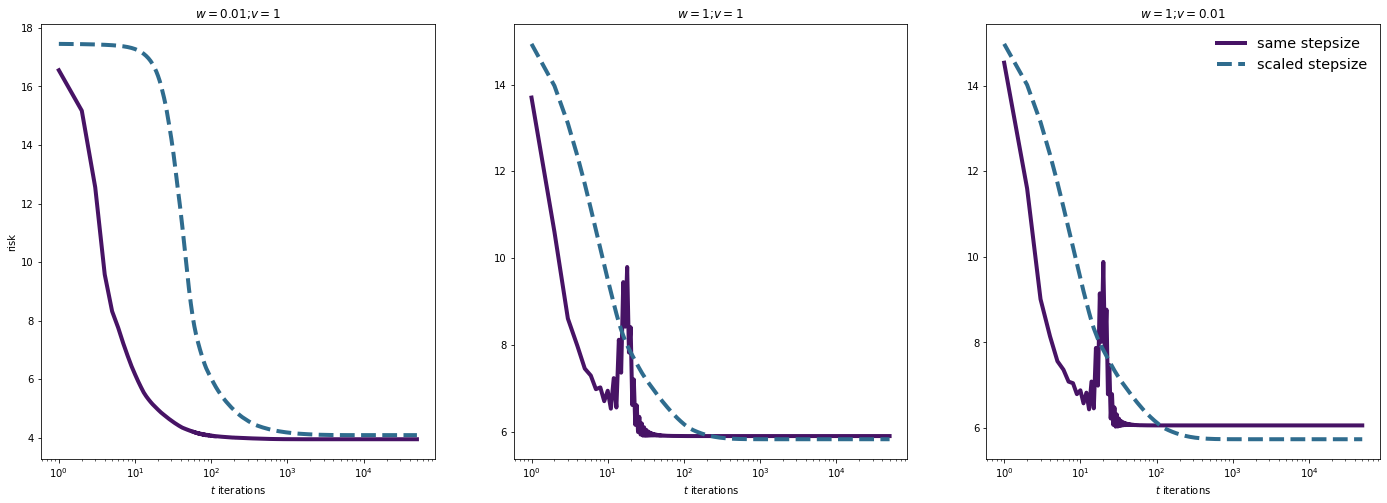

In [6]:
weights = [{'w': 0.01, 'v': 1}, {'w': 1, 'v': 1}, {'w': 1, 'v': 0.01}]
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
labelList = ['same stepsize', 'scaled stepsize']

fig = plt.figure(figsize=(24,8))

ax_list = [plt.subplot(131), plt.subplot(132), plt.subplot(133)]
for i, wlist in enumerate(weights):
    cur_w = wlist['w']
    cur_v = wlist['v']
    
    cur_risks = np.loadtxt('../results/two_layer_nn/' + 
                           'w' + ''.join(str(cur_w).split('.')) + 
                           '_v' + ''.join(str(cur_v).split('.')) +
                           '_lr80/risk.txt',
                          skiprows=1)
    
    ax_list[i].plot(cur_risks[:,0], cur_risks[:,1], 
                    color=colorList[0], 
                    label=labelList[0],
                    lw=4)
    ax_list[i].plot(cur_risks[:,0], cur_risks[:,2], 
                    color=colorList[1], 
                    label=labelList[1],
                    ls='dashed',
                    lw=4)
    
ax_list[-1].legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
                   frameon=False, fancybox=True, shadow=True, ncol=1)
ax_list[0].set_ylabel('risk')

for i, ax in enumerate(ax_list): ax.set_title(r'$w = $' + str(weights[i]['w']) + 
                                              r';$v = $' + str(weights[i]['v']))
for ax in ax_list: ax.set_xlabel(r'$t$ iterations')
for ax in ax_list: ax.set_xscale('log')